In [2]:
import pyvista as pv
import numpy as np
from src.utils.commons import get_config
from src.utils.split_dataset import split_dataset
from src.data.vtu_to_h5 import vtu_to_h5
import os

config = get_config('configs/default.yaml')['config']

sample_size = config['data_sample']
print(f"Dataset directory: {config['dataset_dir']}")
print(f"Split directory: {config['split_dir']}")
print(f"Sample size: {sample_size}")

train_dir, val_dir, test_dir = split_dataset(data_dir=config['dataset_dir'], 
              split_dir=config['split_dir'], 
              sample_size=sample_size,
              overwrite=False)

Dataset directory: ./dataset/cylinder_vonkarman/Re200_cut/flow
Split directory: ./dataset/cylinder_vonkarman/Re200_cut/flow_split
Sample size: 20
split directory ./dataset/cylinder_vonkarman/Re200_cut/flow_split already exists, taking the existing split. Set overwrite to True to overwrite.


In [2]:
sample_file = os.listdir(train_dir)[0]

grid = pv.UnstructuredGrid(os.path.join(train_dir, sample_file))
# grid.plot(show_edges=True)
grid.point_data_to_cell_data()

UnstructuredGrid (0x1f313dbe260)
  N Cells:    30846
  N Points:   15677
  X Bounds:   0.000e+00, 8.000e+00
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [11]:
grid.cells_dict

{np.uint8(5): array([[ 9547, 13100,  3746],
        [ 1211, 14982,  1212],
        [ 8976,  9549,  6709],
        ...,
        [15477, 15622,  9496],
        [15612, 15628,  9177],
        [ 9607, 15628, 15612]])}

In [7]:
nodes_velocities = grid.point_data['Velocity'][:,:2]
cells_velocities = [for cells in grid.cells_dict ]
nodes_velocities

pyvista_ndarray([[ 3.431184e+01, -2.219985e-03],
                 [ 3.426002e+01, -1.506405e-02],
                 [ 3.420773e+01,  8.741924e-02],
                 ...,
                 [ 3.273374e+01,  2.081006e+00],
                 [ 3.439492e+01,  5.981742e-01],
                 [ 3.507108e+01,  2.173622e+00]])

coordinates

In [5]:
coordinates = grid.points[:,:2]
coordinates = coordinates.reshape(-1,2)
coordinates

pyvista_ndarray([[0.      , 0.      ],
                 [8.      , 4.      ],
                 [8.      , 0.      ],
                 ...,
                 [5.511292, 1.570736],
                 [7.931677, 3.55    ],
                 [7.924575, 1.24055 ]])

velocities

In [9]:
grid.point_data['Velocity'][:,1].shape[0]*16

250832

In [5]:
velocities = grid.point_data['Velocity'][:,:2].reshape(-1,2)
velocities = np.array(velocities)
var = {'ux' : velocities[:,0], 'uy' : velocities[:,1]}
var

{'ux': array([34.31184, 34.26002, 34.20773, ..., 32.73374, 34.39492, 35.07108]),
 'uy': array([-0.00221998, -0.01506405,  0.08741924, ...,  2.081006  ,
         0.5981742 ,  2.173622  ])}

converting vtk to h5

In [2]:
splits = ['train', 'val', 'test']
for split in splits:
    vtu_to_h5(os.path.join(config['split_dir'], split), os.path.join(config['split_dir'], f'{split}.h5'))

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\train.h5


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\val.h5


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

Data successfully converted to ./dataset/cylinder_vonkarman/Re200_cut/flow_split\test.h5


In [9]:
import h5py
train_file = h5py.File(os.path.join(config['split_dir'], 'train.h5'), 'r')

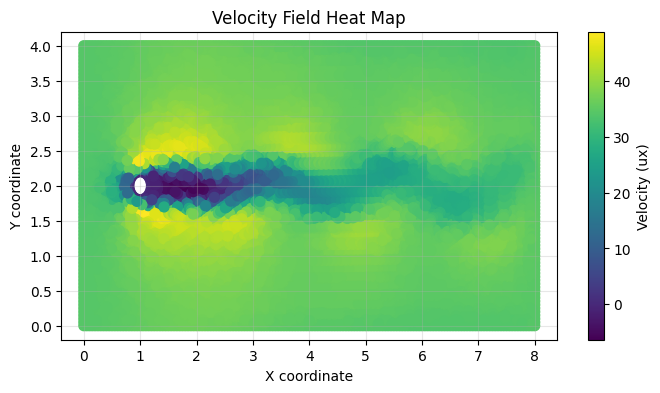

In [40]:
ux_field = list(train_file['flow_00242.vtk']['velocity'][:,0])
uy_field = list(train_file['flow_00242.vtk']['velocity'][:,1])
coordinates = list(train_file['flow_00242.vtk']['coordinates'][:,:2])
# field = np.concatenate((coordinates, ux_field), axis=1)
# field


import matplotlib.pyplot as plt
x = np.array([coord[0] for coord in coordinates])
y = np.array([coord[1] for coord in coordinates])

plt.figure(figsize=(8, 4))
scatter = plt.scatter(x, y, 
                     c=ux_field,  # Color based on ux values
                     cmap='viridis',  # You can change this to other colormaps like 'jet', 'hot', etc.
                     s=50)  # Size of the points
# Add a colorbar
plt.colorbar(scatter, label='Velocity (ux)')

# Add labels and title
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Velocity Field Heat Map')

# Make the plot more readable
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()


In [59]:
# np.concatenate([ux_field, uy_field], axis = 1)
len(ux_field) == len(uy_field)

velocities.shape


(15677, 2)

load mesh

In [9]:
import meshio

config = get_config('configs/default.yaml')['config']

mesh = meshio.read(filename=config['mesh_file'], file_format='vtk')


In [15]:
mesh.cells[2].data

array([[ 9548, 13101,  3747],
       [ 1212, 14983,  1213],
       [ 8977,  9550,  6710],
       ...,
       [15478, 15623,  9497],
       [15613, 15629,  9178],
       [ 9608, 15629, 15613]], dtype=int32)

In [8]:
mesh.cells_dict

{'vertex': array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], dtype=int32),
 'line': array([[  3,   3],
        [  3,   3],
        [  3,   9],
        ...,
        [506, 507],
        [507, 508],
        [508,   7]], dtype=int32),
 'triangle': array([[ 9548, 13101,  3747],
        [ 1212, 14983,  1213],
        [ 8977,  9550,  6710],
        ...,
        [15478, 15623,  9497],
        [15613, 15629,  9178],
        [ 9608, 15629, 15613]], dtype=int32)}

c:\Users\Yuno\anaconda3\envs\'gca_rom'\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


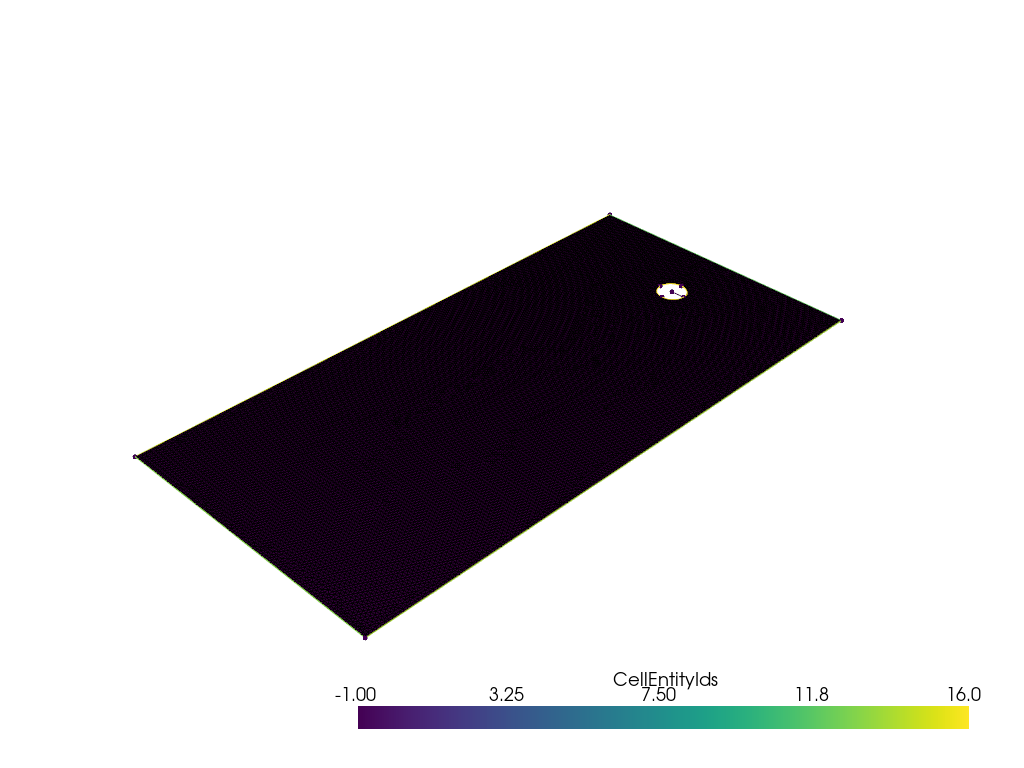

In [ ]:
#plot mesh
import pyvista as pv

# Create a PyVista plotter
plotter = pv.Plotter()

# Add the mesh to the plotter
plotter.add_mesh(mesh, show_edges=True)

# Show the plot
plotter.show()

In [88]:
mesh.points

array([[0.        , 0.        , 0.        ],
       [8.        , 4.        , 0.        ],
       [8.        , 0.        , 0.        ],
       ...,
       [5.51129195, 1.57073571, 0.        ],
       [7.93167654, 3.55      , 0.        ],
       [7.92457525, 1.24054966, 0.        ]])

In [2]:
from src.data.loader import GraphDataset

dataset = GraphDataset()

tensor([[ 3.4326e+01,  9.0210e-03],
        [ 3.4199e+01, -9.3021e-02],
        [ 3.4266e+01,  9.3521e-03],
        ...,
        [ 3.4398e+01, -8.1122e-01],
        [ 3.4385e+01,  9.2174e-02],
        [ 3.5603e+01,  2.6033e+00]])

In [ ]:
np.array(dataset.__getitem__(79).edge_attr)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])